# Clasificación de células cervicales en analisis de PAP en 2 clases (Lesión y NoLesión)

## 1. Preparación de directorios, carga de datos y visualización de imágenes

In [35]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small, EfficientNetB0, ResNet50, EfficientNetB6, Xception
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras_tuner import HyperModel, RandomSearch
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, 
    precision_recall_curve, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_curve, auc as calculate_auc, classification_report, precision_score, recall_score, f1_score


**Preparación de los datos y cargas de imagenes**

In [ ]:
# # Directorio de entrada con las imágenes originales
# input_dir = 'imgs/crops_90x90'
# # Directorio de salida para las imágenes organizadas
# output_dir = 'imgs/crops'

# # Definir carpetas de salida para cada conjunto
# train_dir = os.path.join(output_dir, 'train')
# val_dir = os.path.join(output_dir, 'val')
# test_dir = os.path.join(output_dir, 'test')

# # Crear carpetas principales
# for split_dir in [train_dir, val_dir, test_dir]:
#     os.makedirs(os.path.join(split_dir, '1_lesion'), exist_ok=True)
#     os.makedirs(os.path.join(split_dir, '0_no_lesion', 'Negative'), exist_ok=True)

# # Función para copiar archivos a su destino correspondiente
# def copy_images(images, dest_dir, class_label):
#     lesion_subdir = '1_lesion' if class_label != 'Negative' else '0_no_lesion/Negative'
#     dest_class_dir = os.path.join(dest_dir, lesion_subdir, class_label if class_label != 'Negative' else '')
#     os.makedirs(dest_class_dir, exist_ok=True)
    
#     for img in images:
#         shutil.copy(img, dest_class_dir)

# # Recorrer cada clase en la carpeta de entrada
# for class_name in os.listdir(input_dir):
#     class_path = os.path.join(input_dir, class_name)
    
#     # Asegurarse de que es una carpeta
#     if os.path.isdir(class_path):
#         # Obtener todas las imágenes de esta clase
#         images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

#         # Dividir imágenes en 70% entrenamiento, 15% validación, 15% prueba
#         train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
#         val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

#         # Copiar las imágenes a sus carpetas correspondientes
#         copy_images(train_images, train_dir, class_name)
#         copy_images(val_images, val_dir, class_name)
#         copy_images(test_images, test_dir, class_name)

# print("Imágenes organizadas en carpetas de entrenamiento, validación y prueba dentro de 'crops'.")

**Visualización de Imágenes con y sin Lesiones**

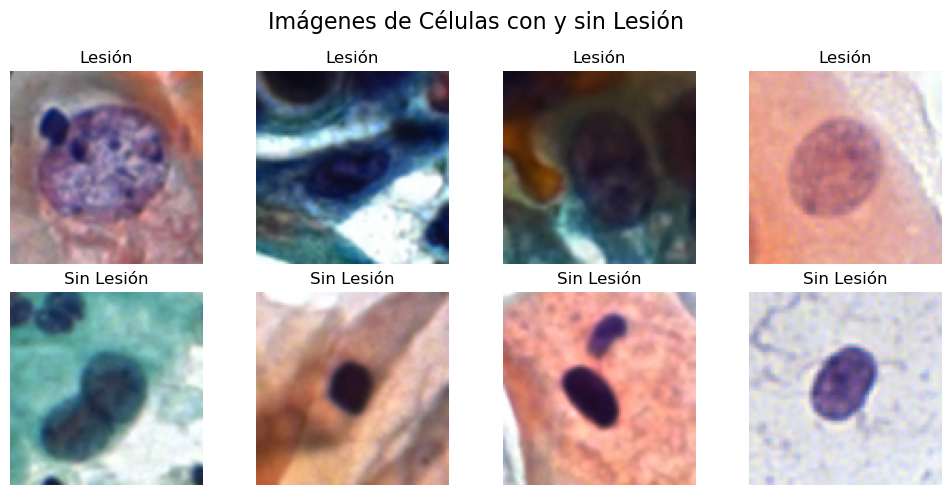

In [34]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Parámetros para la visualización
num_images = 4  # Número de imágenes con y sin lesión que queremos mostrar
image_size = (90, 90)  # Tamaño al que se redimensionarán las imágenes

# Función para visualizar imágenes con y sin lesión
def visualize_images(base_dir, num_images, image_size):
    lesion_folder = os.path.join(base_dir, '1_lesion')
    no_lesion_folder = os.path.join(base_dir, '0_no_lesion', 'Negative')
    
    # Obtener una lista de imágenes con y sin lesión
    lesion_images = []
    for subdir in os.listdir(lesion_folder):
        subdir_path = os.path.join(lesion_folder, subdir)
        if os.path.isdir(subdir_path):
            lesion_images.extend([os.path.join(subdir_path, img) for img in os.listdir(subdir_path)])

    no_lesion_images = [os.path.join(no_lesion_folder, img) for img in os.listdir(no_lesion_folder) if os.path.isfile(os.path.join(no_lesion_folder, img))]

    # Seleccionar aleatoriamente imágenes con y sin lesión
    lesion_images_sample = random.sample(lesion_images, min(num_images, len(lesion_images)))
    no_lesion_images_sample = random.sample(no_lesion_images, min(num_images, len(no_lesion_images)))

    # Visualización
    fig, axes = plt.subplots(2, num_images, figsize=(10, 5))
    fig.suptitle('Imágenes de Células con y sin Lesión', fontsize=16)

    # Mostrar imágenes con lesión
    for i, img_path in enumerate(lesion_images_sample):
        img = load_img(img_path, target_size=image_size)
        axes[0, i].imshow(img)
        axes[0, i].set_title("Lesión")
        axes[0, i].axis('off')
    
    # Mostrar imágenes sin lesión
    for i, img_path in enumerate(no_lesion_images_sample):
        img = load_img(img_path, target_size=image_size)
        axes[1, i].imshow(img)
        axes[1, i].set_title("Sin Lesión")
        axes[1, i].axis('off')
    
    # Ajustar el layout
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

# Llamada a la función para visualizar las imágenes
visualize_images('imgs/crops/test', num_images, image_size)

**Visualización del Balance de las Clases**

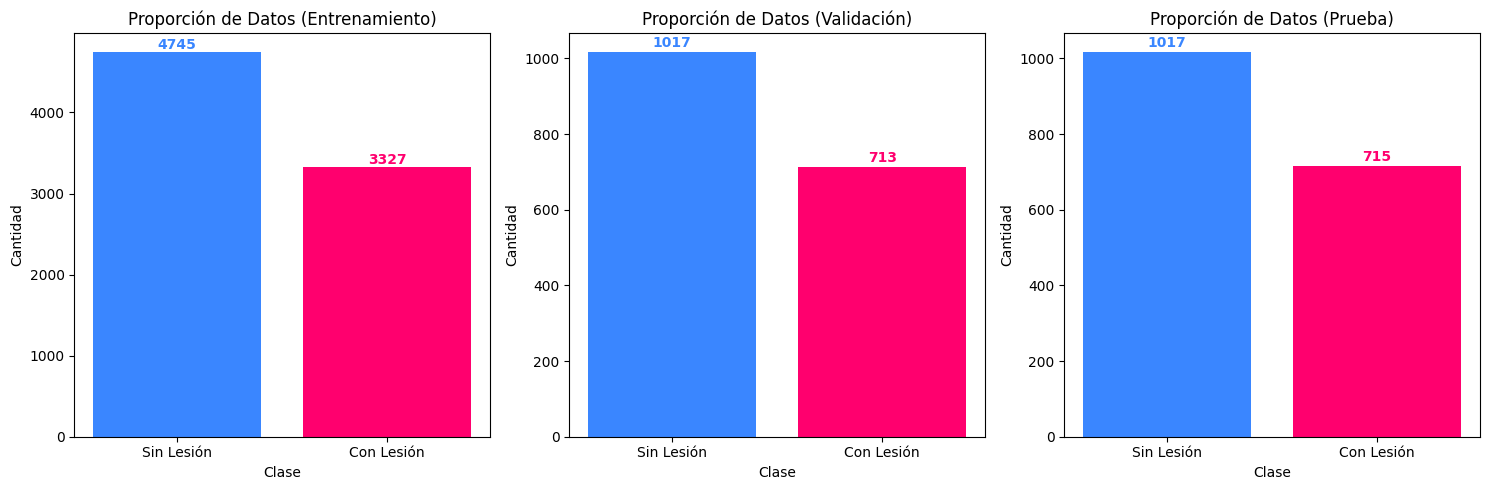

In [ ]:
import os
import matplotlib.pyplot as plt

# Función para contar imágenes en las carpetas "lesion" y "no lesion" en el nuevo formato
def count_images_in_folders(folder_path):
    lesion_folder = os.path.join(folder_path, '1_lesion')
    no_lesion_folder = os.path.join(folder_path, '0_no_lesion', 'Negative')

    # Contar imágenes en las subcarpetas de "con lesión" y "sin lesión"
    lesion_count = sum(len(files) for _, _, files in os.walk(lesion_folder))
    no_lesion_count = len(os.listdir(no_lesion_folder)) if os.path.exists(no_lesion_folder) else 0

    return lesion_count, no_lesion_count

# Función para crear gráficos de barras para las proporciones
def plot_proportion_subplot(ax, lesion_count, no_lesion_count, title):
    # Crear el gráfico de barras en el subplot
    ax.bar(['Sin Lesión', 'Con Lesión'], [no_lesion_count, lesion_count], color=['#3A86FF', '#FF006E'])
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    ax.text(0, no_lesion_count + 5, str(no_lesion_count), ha='center', va='bottom', fontweight='bold', color='#3A86FF')
    ax.text(1, lesion_count + 5, str(lesion_count), ha='center', va='bottom', fontweight='bold', color='#FF006E')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'imgs/crops/train'
val_dir = 'imgs/crops/val'
test_dir = 'imgs/crops/test'

# Contar las imágenes en cada conjunto
train_lesion_count, train_no_lesion_count = count_images_in_folders(train_dir)
val_lesion_count, val_no_lesion_count = count_images_in_folders(val_dir)
test_lesion_count, test_no_lesion_count = count_images_in_folders(test_dir)

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_proportion_subplot(axes[0], train_lesion_count, train_no_lesion_count, 'Proporción de Datos (Entrenamiento)')
plot_proportion_subplot(axes[1], val_lesion_count, val_no_lesion_count, 'Proporción de Datos (Validación)')
plot_proportion_subplot(axes[2], test_lesion_count, test_no_lesion_count, 'Proporción de Datos (Prueba)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

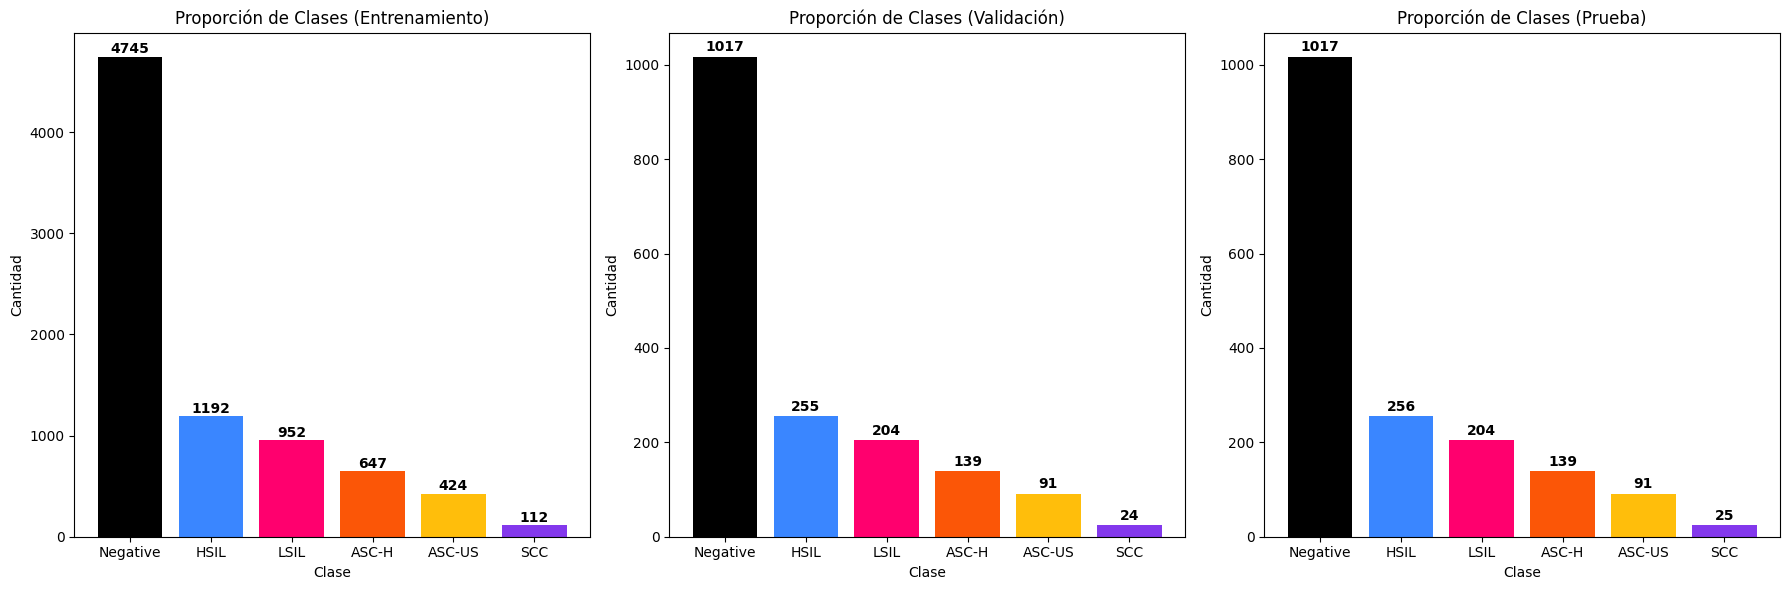

In [ ]:
import os
import matplotlib.pyplot as plt

# Función para contar imágenes por clase dentro de "lesion" y "no lesion" en el nuevo formato
def count_images_by_class(folder_path):
    # Diccionario para almacenar el conteo de cada clase
    class_counts = {}

    # Contar imágenes en la carpeta "0_no_lesion/Negative"
    no_lesion_folder = os.path.join(folder_path, '0_no_lesion', 'Negative')
    class_counts['Negative'] = len(os.listdir(no_lesion_folder)) if os.path.exists(no_lesion_folder) else 0

    # Contar imágenes en cada subcarpeta de "1_lesion"
    lesion_folder = os.path.join(folder_path, '1_lesion')
    for lesion_class in os.listdir(lesion_folder):
        lesion_class_path = os.path.join(lesion_folder, lesion_class)
        if os.path.isdir(lesion_class_path):
            class_counts[lesion_class] = len(os.listdir(lesion_class_path))

    return class_counts

# Función para crear gráficos de barras para las proporciones de cada clase
def plot_class_proportion(ax, class_counts, title, colors):
    # Crear el gráfico de barras en el subplot
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    ax.bar(classes, counts, color=colors[:len(classes)])
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    for i, count in enumerate(counts):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'imgs/crops/train'
val_dir = 'imgs/crops/val'
test_dir = 'imgs/crops/test'

# Contar las imágenes en cada conjunto por clase
train_class_counts = count_images_by_class(train_dir)
val_class_counts = count_images_by_class(val_dir)
test_class_counts = count_images_by_class(test_dir)

# Colores para cada clase
colors = ['#000000', '#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC']  # Negro para 'Negative' y colores para las clases con lesión

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_class_proportion(axes[0], train_class_counts, 'Proporción de Clases (Entrenamiento)', colors)
plot_class_proportion(axes[1], val_class_counts, 'Proporción de Clases (Validación)', colors)
plot_class_proportion(axes[2], test_class_counts, 'Proporción de Clases (Prueba)', colors)

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

## 2. Aumentación de Datos para la Clase Minoritaria

El objetivo de este proceso es generar imágenes augmentadas para las clases minoritarias SCC, ASC-US, y ASC-H en el conjunto de entrenamiento, utilizando técnicas de aumentación de datos como rotación, volteo horizontal y vertical, y ajustes de brillo. Estas transformaciones ayudan a aumentar la variabilidad de las imágenes de la clase con lesión, reduciendo el desequilibrio de clases y mejorando la capacidad del modelo para generalizar. 
Este proceso generará aproximadamente 1.5 veces la cantidad actual de cada clase minoritaria, de modo que se acerquen a la proporción de las clases mayoritarias (LSIL y HSIL) sin sobrecargar el modelo con demasiados datos.

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

# Directorio de entrenamiento
train_dir = 'imgs/crops_aug/train/1_lesion'

# Clases minoritarias para las que realizaremos aumentación
minority_classes = {
    'SCC': 112,
    'ASC-US': 424,
    'ASC-H': 647
}

# Objetivo de aumentación
augmentation_targets = {
    'SCC': 168,
    'ASC-US': 636,
    'ASC-H': 970
}

# Configuración de aumentación
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Función para generar imágenes aumentadas
def augment_class_images(class_name, current_count, target_count):
    class_dir = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_dir)

    # Generar imágenes hasta alcanzar el target_count
    while current_count < target_count:
        img_path = os.path.join(class_dir, np.random.choice(image_files))
        img = load_img(img_path)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Generar una imagen aumentada
        aug_iter = datagen.flow(img_array, batch_size=1)
        aug_img = next(aug_iter)[0].astype(np.uint8)

        # Guardar la imagen aumentada
        new_img_name = f"{class_name}_aug_{current_count}.png"
        save_img(os.path.join(class_dir, new_img_name), aug_img)
        
        current_count += 1

# Aplicar aumentación a cada clase minoritaria
for class_name, current_count in minority_classes.items():
    target_count = augmentation_targets[class_name]
    print(f"Generando aumentación para la clase {class_name}: de {current_count} a {target_count} imágenes.")
    augment_class_images(class_name, current_count, target_count)

print("Aumentación de datos completada para las clases minoritarias.")

Generando aumentación para la clase SCC: de 112 a 168 imágenes.
Generando aumentación para la clase ASC-US: de 424 a 636 imágenes.
Generando aumentación para la clase ASC-H: de 647 a 970 imágenes.
Aumentación de datos completada para las clases minoritarias.


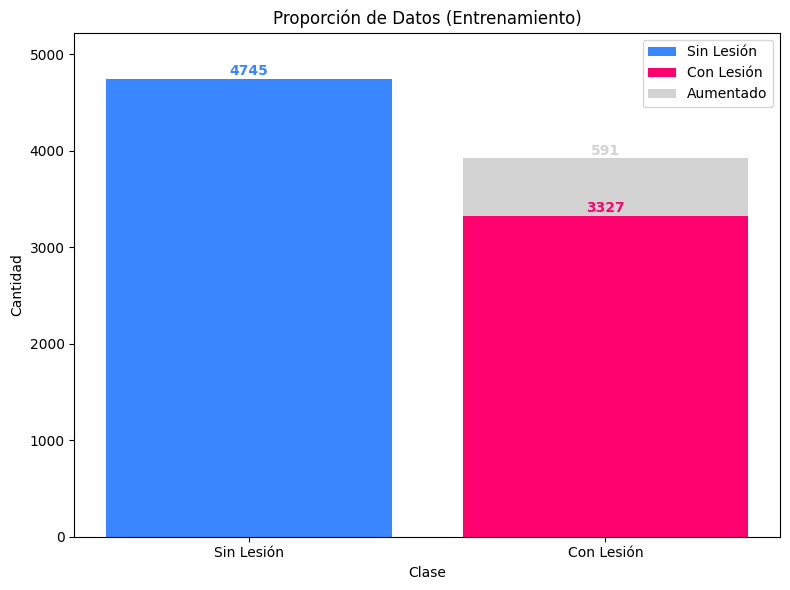

In [ ]:
import os
import matplotlib.pyplot as plt

# Función para contar imágenes en las carpetas, incluyendo las aumentadas basadas en el prefijo del nombre
def count_images_in_folders(folder_path):
    lesion_count = 0
    no_lesion_count = 0
    augmented_count = 0

    lesion_folder_path = os.path.join(folder_path, '1_lesion')
    no_lesion_folder_path = os.path.join(folder_path, '0_no_lesion', 'Negative')
    
    # Contar imágenes originales y aumentadas en "con lesión"
    if os.path.exists(lesion_folder_path):
        for class_folder in os.listdir(lesion_folder_path):
            class_folder_path = os.path.join(lesion_folder_path, class_folder)
            if os.path.isdir(class_folder_path):
                for img_file in os.listdir(class_folder_path):
                    # Verificar si el nombre del archivo coincide con el patrón de aumento
                    if "_aug_" in img_file:
                        augmented_count += 1
                    else:
                        lesion_count += 1

    # Contar imágenes en "sin lesión" (clase Negative)
    if os.path.exists(no_lesion_folder_path):
        no_lesion_count = len(os.listdir(no_lesion_folder_path))

    return lesion_count, no_lesion_count, augmented_count

# Función para crear el gráfico de barras, incluyendo augmentación
def plot_proportion_train(lesion_count, no_lesion_count, augmented_count):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Graficar datos originales y augmentados
    ax.bar(['Sin Lesión', 'Con Lesión'], [no_lesion_count, lesion_count], color=['#3A86FF', '#FF006E'], label=['Sin Lesión', 'Con Lesión'])
    ax.bar(['Sin Lesión', 'Con Lesión'], [0, augmented_count], bottom=[no_lesion_count, lesion_count], 
           color='#D3D3D3', label='Aumentado')  # Color distinto para los aumentados
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title('Proporción de Datos (Entrenamiento)')
    
    # Agregar etiquetas de cantidad en las barras
    ax.text(0, no_lesion_count + 5, str(no_lesion_count), ha='center', va='bottom', fontweight='bold', color='#3A86FF')
    ax.text(1, lesion_count + 5, str(lesion_count), ha='center', va='bottom', fontweight='bold', color='#FF006E')
    ax.text(1, lesion_count + augmented_count + 5, f"{augmented_count}", ha='center', va='bottom', fontweight='bold', color='#D3D3D3')
    
    # Ajustar el límite del eje y
    ax.set_ylim(0, max(no_lesion_count, lesion_count + augmented_count) * 1.1)

    # Añadir leyenda
    ax.legend()
    plt.tight_layout()
    plt.show()

# Directorio de entrenamiento
train_dir = 'imgs/crops_aug/train'

# Contar las imágenes en el conjunto de entrenamiento
train_lesion_count, train_no_lesion_count, train_augmented_count = count_images_in_folders(train_dir)

# Crear gráfico de entrenamiento con datos augmentados
plot_proportion_train(train_lesion_count, train_no_lesion_count, train_augmented_count)

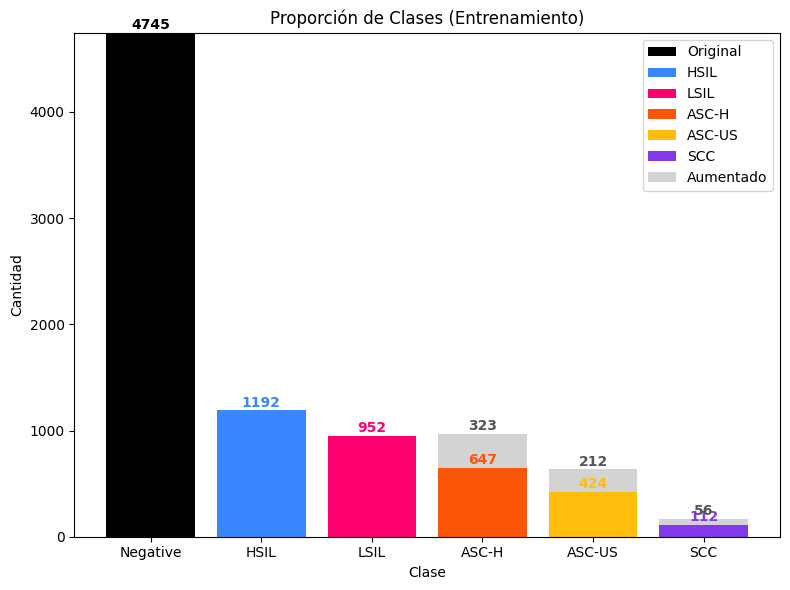

In [ ]:
import os
import matplotlib.pyplot as plt

# Función para contar imágenes originales y aumentadas por clase en el conjunto de entrenamiento
def count_images_by_class_with_augmentation(folder_path):
    class_counts = {}
    augmented_counts = {}

    # Contar imágenes en la carpeta "0_no_lesion/Negative"
    no_lesion_folder = os.path.join(folder_path, '0_no_lesion', 'Negative')
    class_counts['Negative'] = len([img for img in os.listdir(no_lesion_folder) if "_aug_" not in img]) if os.path.exists(no_lesion_folder) else 0
    augmented_counts['Negative'] = len([img for img in os.listdir(no_lesion_folder) if "_aug_" in img]) if os.path.exists(no_lesion_folder) else 0

    # Contar imágenes en cada subcarpeta de "1_lesion"
    lesion_folder = os.path.join(folder_path, '1_lesion')
    for lesion_class in os.listdir(lesion_folder):
        lesion_class_path = os.path.join(lesion_folder, lesion_class)
        if os.path.isdir(lesion_class_path):
            class_counts[lesion_class] = len([img for img in os.listdir(lesion_class_path) if "_aug_" not in img])
            augmented_counts[lesion_class] = len([img for img in os.listdir(lesion_class_path) if "_aug_" in img])

    return class_counts, augmented_counts

# Función para crear el gráfico de barras del conjunto de entrenamiento, incluyendo aumentación
def plot_class_proportion_with_augmentation(class_counts, augmented_counts, title, colors):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    augmented = [augmented_counts[cls] for cls in classes]

    # Graficar datos originales y augmentados
    bars_original = ax.bar(classes, counts, color=colors[:len(classes)], label=['Original', 'HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC'])
    bars_augmented = ax.bar(classes, augmented, bottom=counts, color='#D3D3D3', label='Aumentado')  # Color gris claro para aumentados

    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)

    # Agregar etiquetas de cantidad en las barras, con el color de cada barra
    for bar, count, color in zip(bars_original, counts, colors):
        ax.text(bar.get_x() + bar.get_width() / 2, count + 5, str(count), ha='center', va='bottom', fontweight='bold', color=color)
    
    for bar, count, aug in zip(bars_augmented, counts, augmented):
        if aug > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, count + aug + 5, str(aug), ha='center', va='bottom', fontweight='bold', color='#555555')

    # Añadir leyenda y mostrar gráfico
    ax.legend()
    plt.tight_layout()
    plt.show()

# Directorio de entrenamiento
train_dir = 'imgs/crops_aug/train'

# Contar las imágenes en el conjunto de entrenamiento
train_class_counts, train_augmented_counts = count_images_by_class_with_augmentation(train_dir)

# Colores para cada clase
colors = ['#000000', '#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC']

# Crear gráfico solo del conjunto de entrenamiento con datos aumentados
plot_class_proportion_with_augmentation(train_class_counts, train_augmented_counts, 'Proporción de Clases (Entrenamiento)', colors)

## 3. Generación de imagenes

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorios de entrenamiento, validación y prueba en la nueva estructura de carpetas
train_dir = 'imgs/crops_2classes/train'
val_dir = 'imgs/crops_2classes/val'
test_dir = 'imgs/crops_2classes/test'

# Configuración del generador de imágenes con reescalado
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generador de imágenes para el entrenamiento binario completo (con y sin lesión)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Asegura que el modo sea binario
    shuffle=True
)

# Generadores para validación y prueba (binarios)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 8072 images belonging to 2 classes.
Found 1730 images belonging to 2 classes.
Found 1732 images belonging to 2 classes.


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

train_generator_aug = train_datagen.flow_from_directory(
    'imgs/crops_2classes_aug/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  
    shuffle=True
)

Found 8663 images belonging to 2 classes.


## 4. Entrenamiento y Evaluación de modelos de clasificación binaria

### MovileNetV2

In [ ]:
# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout con un 30% de desactivación de neuronas
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 30 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc')])  #tf.keras.metrics.F1Score(name='f1_score')]) 

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator, 
)

Epoch 1/30
253/253 [==============================] - 97s 377ms/step - loss: 0.5249 - accuracy: 0.7288 - precision: 0.6873 - recall: 0.6276 - auc: 0.8057 - val_loss: 0.6291 - val_accuracy: 0.6474 - val_precision: 0.8601 - val_recall: 0.1725 - val_auc: 0.8376
Epoch 2/30
253/253 [==============================] - 93s 368ms/step - loss: 0.3899 - accuracy: 0.8209 - precision: 0.7802 - recall: 0.7872 - auc: 0.9011 - val_loss: 0.5486 - val_accuracy: 0.7168 - val_precision: 0.8968 - val_recall: 0.3534 - val_auc: 0.8817
Epoch 3/30
253/253 [==============================] - 95s 377ms/step - loss: 0.3432 - accuracy: 0.8507 - precision: 0.8192 - recall: 0.8185 - auc: 0.9252 - val_loss: 0.4438 - val_accuracy: 0.7942 - val_precision: 0.9103 - val_recall: 0.5554 - val_auc: 0.9107
Epoch 4/30
253/253 [==============================] - 97s 382ms/step - loss: 0.3095 - accuracy: 0.8677 - precision: 0.8399 - recall: 0.8389 - auc: 0.9392 - val_loss: 0.3856 - val_accuracy: 0.8347 - val_precision: 0.9036 - v

#### Evaluación

55/55 [==============================] - 12s 210ms/step
Precisión: 0.8652
Recall: 0.8615
F1-Score: 0.8633
AUC: 0.9505


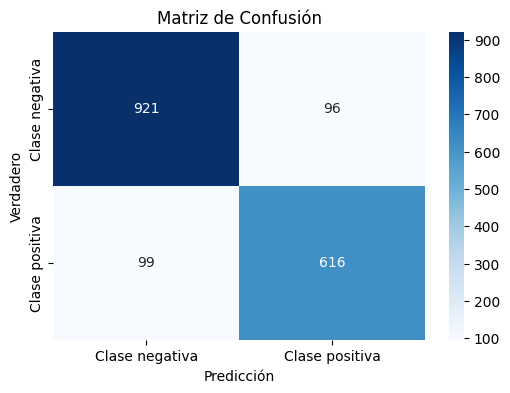

In [ ]:
threshold = 0.6

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_probs = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_probs > threshold).astype(int) 

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)] 

# Calcular y visualizar métricas
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs) 

# Mostrar las métricas
print(f'Precisión: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')

# Mostrar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase negativa', 'Clase positiva'], yticklabels=['Clase negativa', 'Clase positiva'])
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()

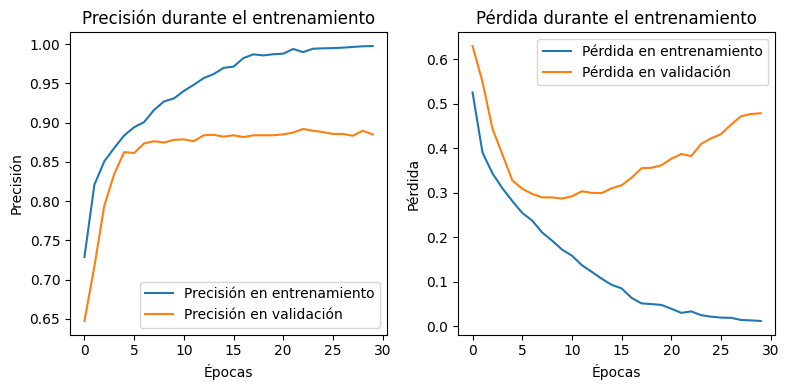

In [35]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_generator, 
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
# print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 12s 225ms/step - loss: 0.4742 - accuracy: 0.8874 - precision: 0.8562 - recall: 0.8741 - auc: 0.9403
Pérdida en el conjunto de prueba: 0.4741659462451935
accuracy en el conjunto de prueba: 0.8874133825302124
Precision en el conjunto de prueba: 0.8561643958091736
Recall en el conjunto de prueba: 0.8741258978843689
AUC en el conjunto de prueba: 0.9402989149093628


55/55 [==============================] - 12s 226ms/step


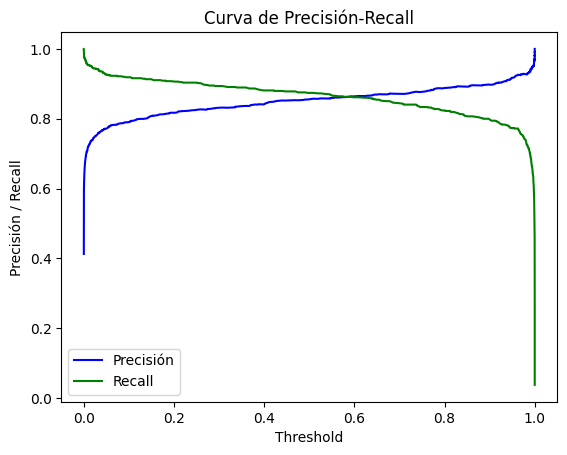

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

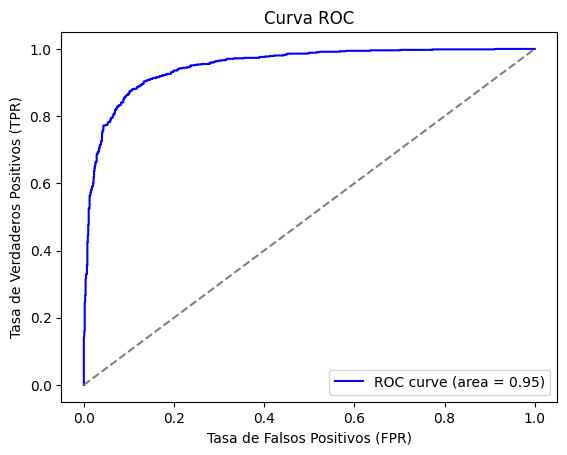

In [15]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Ajustar el umbral de decisión
new_threshold = 0.6
y_pred_class = (y_pred_proba >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
# f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_proba)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'AUC: {auc_score}')

Precisión: 0.8651685393258427
Recall: 0.8615384615384616
AUC: 0.9504603557700904


### MobileNetV3

In [ ]:
# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(54, activation='relu'),
    layers.Dropout(0.5),  # Dropout con un 30% de desactivación de neuronas
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.F1Score(name='f1_score')]) 

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,  # Generador para los datos de validación
)

Epoch 1/30
284/284 [==============================] - 13s 28ms/step - loss: 0.6223 - accuracy: 0.6533 - precision: 0.6389 - recall: 0.6282 - auc: 0.7132 - f1_score: 0.6459 - val_loss: 0.6905 - val_accuracy: 0.5861 - val_precision: 0.4800 - val_recall: 0.0505 - val_auc: 0.5598 - val_f1_score: 0.5837
Epoch 2/30
284/284 [==============================] - 7s 23ms/step - loss: 0.5517 - accuracy: 0.7225 - precision: 0.7021 - recall: 0.7264 - auc: 0.7941 - f1_score: 0.6459 - val_loss: 0.6916 - val_accuracy: 0.5821 - val_precision: 0.3810 - val_recall: 0.0224 - val_auc: 0.4239 - val_f1_score: 0.5837
Epoch 3/30
284/284 [==============================] - 7s 24ms/step - loss: 0.5163 - accuracy: 0.7542 - precision: 0.7327 - recall: 0.7632 - auc: 0.8245 - f1_score: 0.6459 - val_loss: 0.6931 - val_accuracy: 0.5289 - val_precision: 0.3658 - val_recall: 0.1950 - val_auc: 0.4448 - val_f1_score: 0.5837
Epoch 4/30
284/284 [==============================] - 7s 23ms/step - loss: 0.5022 - accuracy: 0.7614 -

#### Evaluación

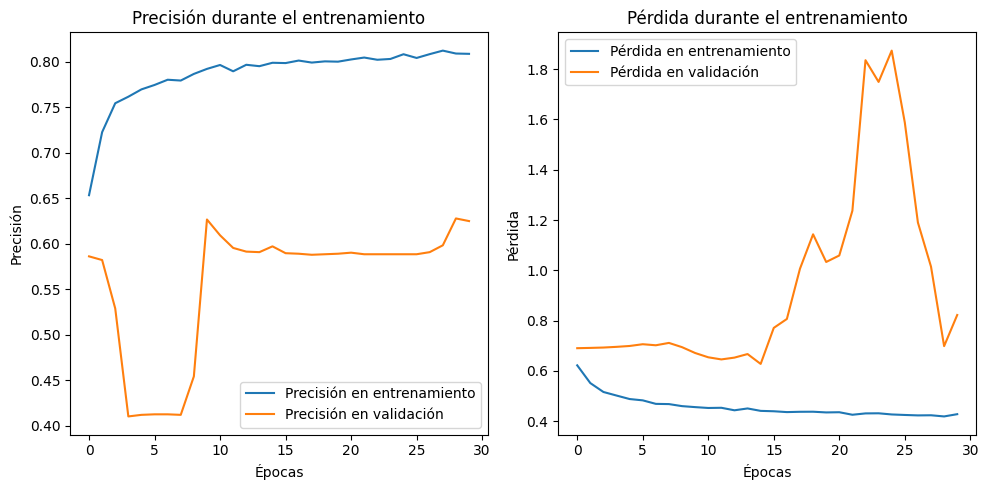

In [ ]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 1s 23ms/step - loss: 0.8213 - accuracy: 0.6320 - precision: 0.9326 - recall: 0.1162 - auc: 0.8956 - f1_score: 0.5840
Pérdida en el conjunto de prueba: 0.821283221244812
accuracy en el conjunto de prueba: 0.6320046186447144
Precision en el conjunto de prueba: 0.932584285736084
Recall en el conjunto de prueba: 0.11624649912118912
AUC en el conjunto de prueba: 0.8955858945846558
F1-Score en el conjunto de prueba: [0.58404905]


**Matriz de confusión**

55/55 [==============================] - 1s 23ms/step


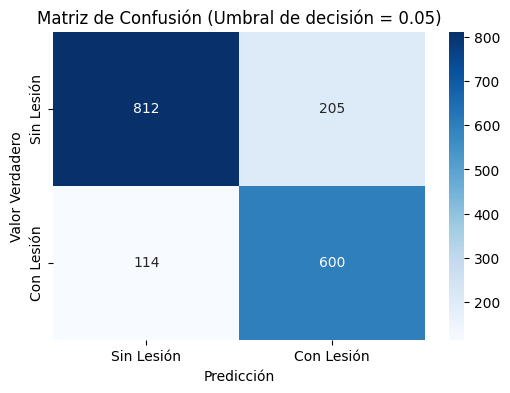

Recall (con umbral = 0.05): 0.8403361344537815
Precisión (con umbral = 0.05): 0.7453416149068323


In [ ]:
# Definir el nuevo umbral de decisión
threshold = 0.05  

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int) 


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 1s 19ms/step


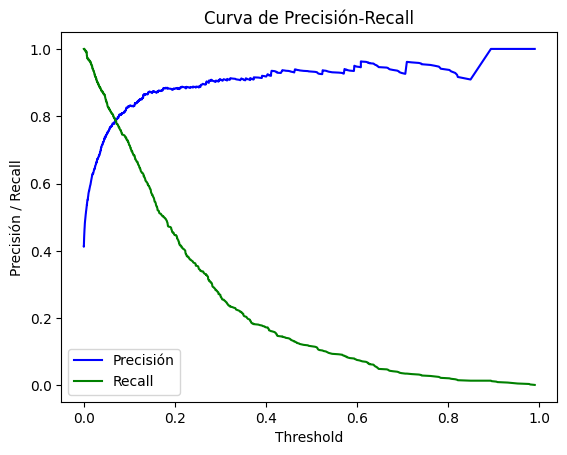

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)] 

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

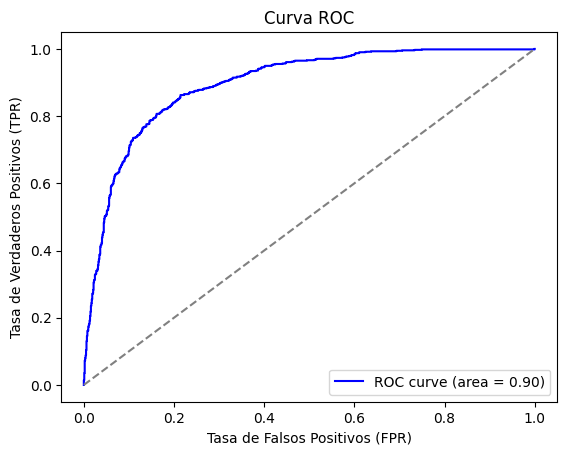

In [ ]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Ajustar el umbral de decisión
new_threshold = 0.4
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.5696619950535862
Recall: 0.9677871148459384
F1-Score: 0.7171769590036325
AUC: 0.8900883854033256


In [ ]:
y_pred_proba = model.predict(test_generator) # probabilidades predichas
y_true = test_generator.classes  # Etiquetas verdaderas (0 o 1)

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int) 
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 1s 20ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.05
Mejor F1-score: 0.7899934167215273


### EfficientNetB0

In [ ]:
# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB0(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar inicialmente todas las capas del modelo base
base_model.trainable = False

# Crear el modelo final con regularización L2 y Dropout para reducir el sobreajuste
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Usamos GlobalAveragePooling2D que es común para EfficientNet
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base para ajuste fino (fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-10]:  
    layer.trainable = False

# Callback para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Early stopping para evitar sobreajuste y parar el entrenamiento temprano
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilar el modelo con una tasa de aprendizaje más alta (y Adam como optimizador)
model.compile(optimizer=Adam(learning_rate=1e-4),  # Aumentar tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])  # Métricas añadidas

# Entrenar el modelo con callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],  
    class_weight={0: 1., 1: 3.0}  # Ajustar class_weight para clases desbalanceadas
)

Epoch 1/30
253/253 [==============================] - 113s 434ms/step - loss: 1.8180 - accuracy: 0.4155 - precision: 0.4124 - recall: 0.9841 - auc: 0.5093 - f1_score: 0.5093 - val_loss: 1.2881 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.6226 - val_f1_score: 0.6226 - lr: 1.0000e-04
Epoch 2/30
253/253 [==============================] - 108s 425ms/step - loss: 1.6827 - accuracy: 0.4150 - precision: 0.4128 - recall: 0.9922 - auc: 0.5259 - f1_score: 0.5259 - val_loss: 1.2449 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.6830 - val_f1_score: 0.6830 - lr: 1.0000e-04
Epoch 3/30
253/253 [==============================] - 108s 428ms/step - loss: 1.5955 - accuracy: 0.4130 - precision: 0.4125 - recall: 0.9997 - auc: 0.5091 - f1_score: 0.5091 - val_loss: 1.1634 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.7124 - val_f1_score: 0.7124 - lr: 1.0000e-04
Epoch 4/30
253/253 [=======================

#### Evaluación

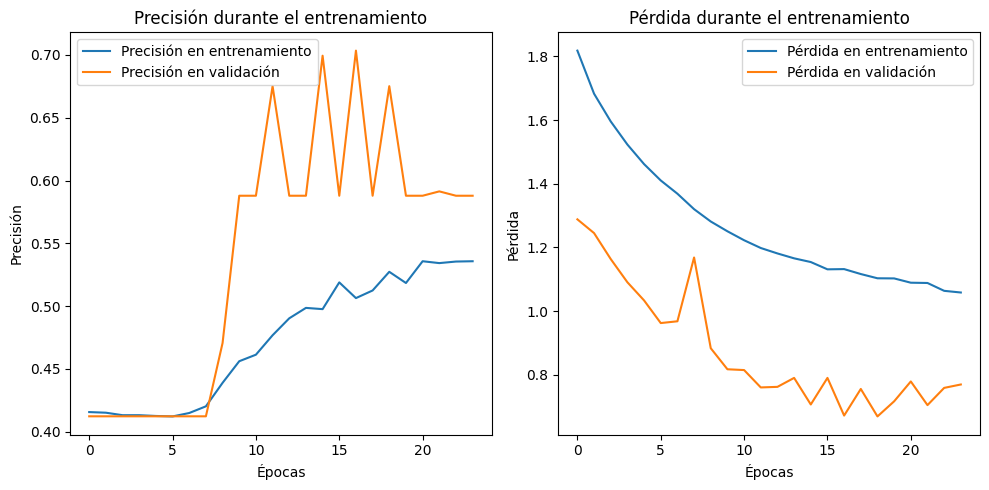

In [65]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [66]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 35s 633ms/step - loss: 0.6622 - accuracy: 0.6894 - precision: 0.5984 - recall: 0.7524 - auc: 0.7702 - f1_score: 0.7702
Pérdida en el conjunto de prueba: 0.6621899604797363
accuracy en el conjunto de prueba: 0.6893764138221741
Precision en el conjunto de prueba: 0.5984427332878113
Recall en el conjunto de prueba: 0.7524475455284119
AUC en el conjunto de prueba: 0.7701693773269653
F1-Score en el conjunto de prueba: 0.7701693773269653


**Matriz de confusión**

55/55 [==============================] - 37s 654ms/step


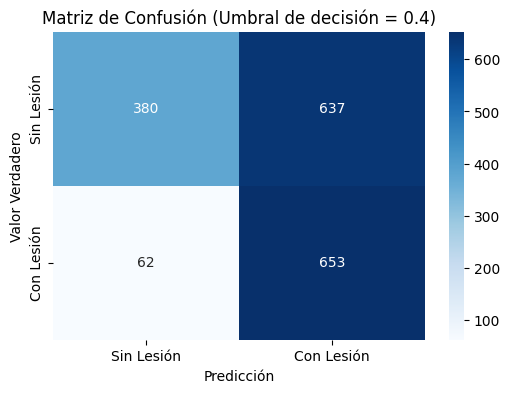

Recall (con umbral = 0.4): 0.9132867132867133
Precisión (con umbral = 0.4): 0.506201550387597


In [ ]:
# Definir el nuevo umbral de decisión
threshold = 0.4  

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int) 


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 39s 712ms/step


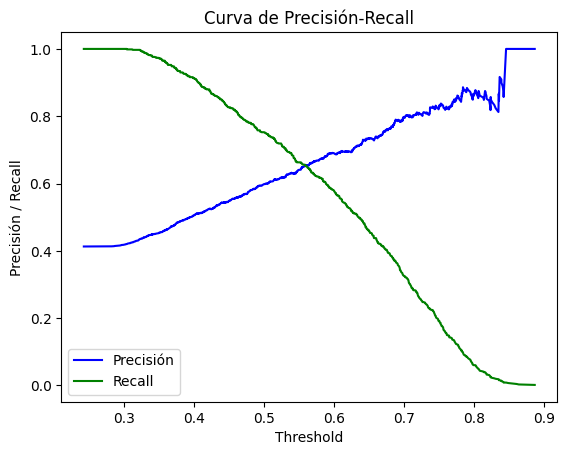

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

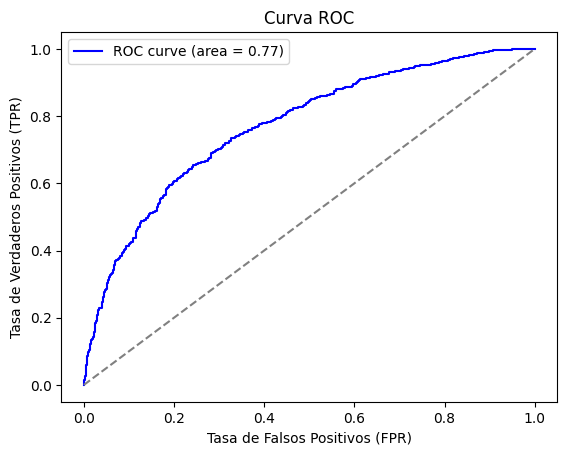

In [69]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1: 
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 35s 628ms/step
Dimensiones de y_pred_proba: (1732, 1)
Dimensiones de y_true: (1732,)
Mejor threshold para F1-score: 0.5
Mejor F1-score: 0.6666666666666667


### ResNet

In [ ]:
# Cargar ResNet50 preentrenado en ImageNet, sin la capa superior
base_model = ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  # Incrementar el dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar algunas capas del modelo base para ajustar los pesos
base_model.trainable = True
for layer in base_model.layers[:-30]: 
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje más baja
model.compile(optimizer=Adam(learning_rate=1e-5),  
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.F1Score(name='f1_score')]) 

# Aplicar class_weight para manejar el desbalanceo de clases
class_weight = {0: 1., 1: 3.5}  # Dar más peso a la clase con "lesión"

history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,
)

Epoch 1/30
253/253 [==============================] - 84s 325ms/step - loss: 0.4925 - accuracy: 0.7551 - precision: 0.7075 - recall: 0.6920 - auc: 0.8330 - f1_score: 0.5838 - val_loss: 0.6210 - val_accuracy: 0.6387 - val_precision: 0.5357 - val_recall: 0.9257 - val_auc: 0.8280 - val_f1_score: 0.5837
Epoch 2/30
253/253 [==============================] - 81s 321ms/step - loss: 0.4327 - accuracy: 0.7983 - precision: 0.7549 - recall: 0.7563 - auc: 0.8765 - f1_score: 0.5838 - val_loss: 0.4052 - val_accuracy: 0.8197 - val_precision: 0.8463 - val_recall: 0.6872 - val_auc: 0.9006 - val_f1_score: 0.5837
Epoch 3/30
253/253 [==============================] - 88s 349ms/step - loss: 0.4170 - accuracy: 0.8117 - precision: 0.7739 - recall: 0.7674 - auc: 0.8859 - f1_score: 0.5838 - val_loss: 0.4363 - val_accuracy: 0.7931 - val_precision: 0.8884 - val_recall: 0.5694 - val_auc: 0.9034 - val_f1_score: 0.5837
Epoch 4/30
253/253 [==============================] - 83s 330ms/step - loss: 0.4051 - accuracy: 0

#### Evaluación

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 8s 150ms/step - loss: 0.5589 - accuracy: 0.7880 - precision: 0.8505 - recall: 0.5896 - auc: 0.8801 - f1_score: 0.5840
Pérdida en el conjunto de prueba: 0.5589182376861572
accuracy en el conjunto de prueba: 0.7879838347434998
Precision en el conjunto de prueba: 0.8505050539970398
Recall en el conjunto de prueba: 0.5896358489990234
AUC en el conjunto de prueba: 0.8801308870315552
F1-Score en el conjunto de prueba: [0.58404905]


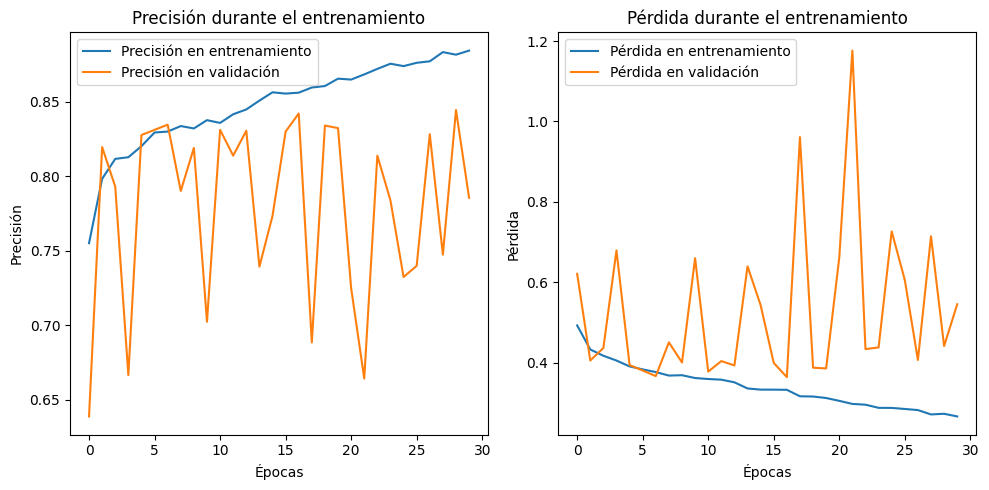

In [ ]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

**Matriz de confusión**

55/55 [==============================] - 9s 160ms/step


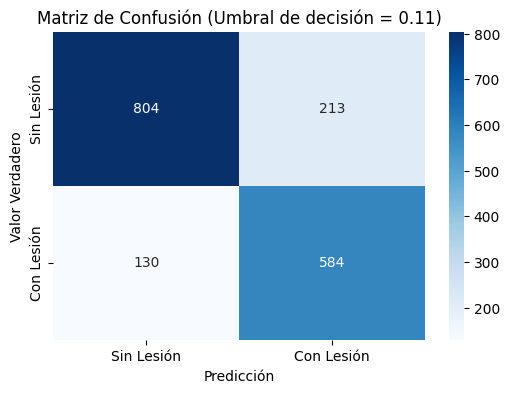

Recall (con umbral = 0.11): 0.8179271708683473
Precisión (con umbral = 0.11): 0.7327478042659975


In [ ]:
# Definir el nuevo umbral de decisión
threshold = 0.11 

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convertir las probabilidades a etiquetas binarias basadas en el umbral definido
y_pred = (y_pred_proba > threshold).astype(int)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 8s 152ms/step


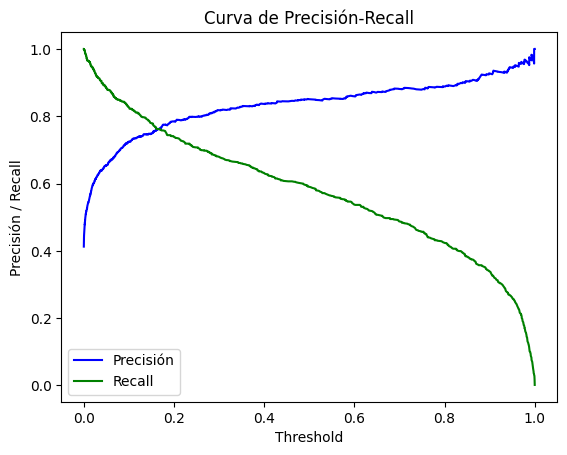

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)] 

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

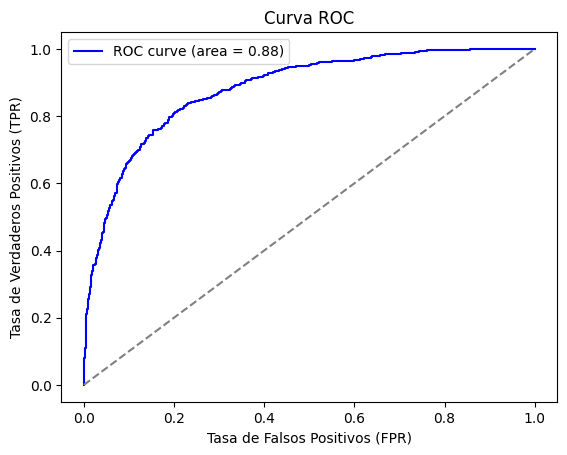

In [ ]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator) 
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1: 
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

55/55 [==============================] - 9s 170ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.11
Mejor F1-score: 0.7729980145598941


### EfficientNetB6

In [ ]:
# Cargar EfficientNetB6 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB6(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar inicialmente todas las capas del modelo base
base_model.trainable = False

# Crear el modelo final con regularización L2 y Dropout para reducir el sobreajuste
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Usamos GlobalAveragePooling2D que es común para EfficientNet
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base para ajuste fino (fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-10]:  
    layer.trainable = False

# Callback para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Early stopping para evitar sobreajuste y parar el entrenamiento temprano
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilar el modelo con una tasa de aprendizaje más alta (y Adam como optimizador)
model.compile(optimizer=Adam(learning_rate=1e-4),  
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])  # Métricas añadidas

# Entrenar el modelo con callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping], 
)

165234480/165234480 [==============================] - 12s 0us/step
Epoch 1/30
284/284 [==============================] - 99s 315ms/step - loss: 0.8230 - accuracy: 0.5123 - precision: 0.4868 - recall: 0.4147 - auc: 0.5146 - f1_score: 0.5146 - val_loss: 0.8199 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.5717 - val_f1_score: 0.5717 - lr: 1.0000e-04
Epoch 2/30
284/284 [==============================] - 83s 293ms/step - loss: 0.7980 - accuracy: 0.5240 - precision: 0.5015 - recall: 0.3533 - auc: 0.5267 - f1_score: 0.5267 - val_loss: 0.7774 - val_accuracy: 0.6133 - val_precision: 0.5733 - val_recall: 0.2412 - val_auc: 0.6080 - val_f1_score: 0.6080 - lr: 1.0000e-04
Epoch 3/30
284/284 [==============================] - 84s 297ms/step - loss: 0.7825 - accuracy: 0.5423 - precision: 0.5301 - recall: 0.3563 - auc: 0.5473 - f1_score: 0.5473 - val_loss: 0.7669 - val_accuracy: 0.6075 - val_precision: 0.6062 - val_recall: 0.1360 - val_auc: 0.6172 - val_f1_score: 0.

#### Evaluación

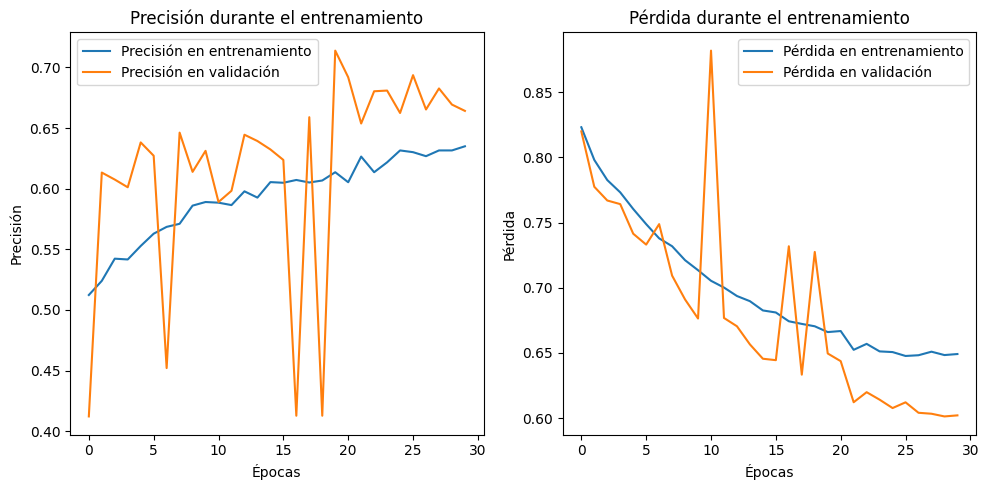

In [ ]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 14s 260ms/step - loss: 0.5962 - accuracy: 0.6742 - precision: 0.7206 - recall: 0.3431 - auc: 0.7889 - f1_score: 0.7889
Pérdida en el conjunto de prueba: 0.5962381362915039
accuracy en el conjunto de prueba: 0.6741767525672913
Precision en el conjunto de prueba: 0.720588207244873
Recall en el conjunto de prueba: 0.343137264251709
AUC en el conjunto de prueba: 0.7889147996902466
F1-Score en el conjunto de prueba: 0.7889147996902466


**Matriz de confusión**

55/55 [==============================] - 13s 227ms/step


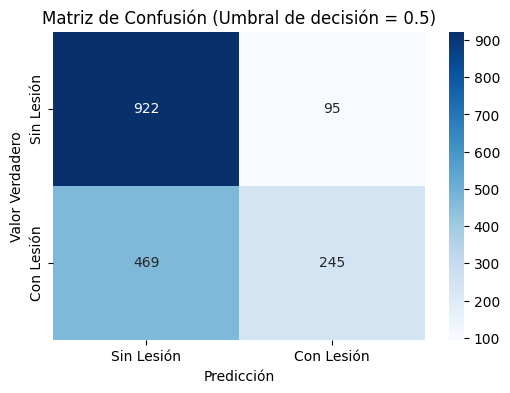

Recall (con umbral = 0.5): 0.3431372549019608
Precisión (con umbral = 0.5): 0.7205882352941176


In [ ]:
# Definir el nuevo umbral de decisión
threshold = 0.5 

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 13s 238ms/step


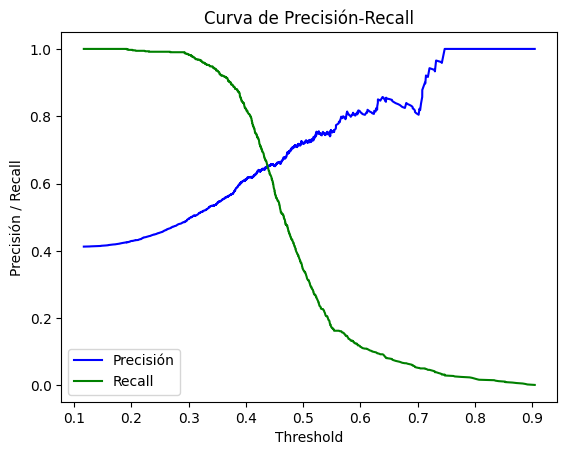

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

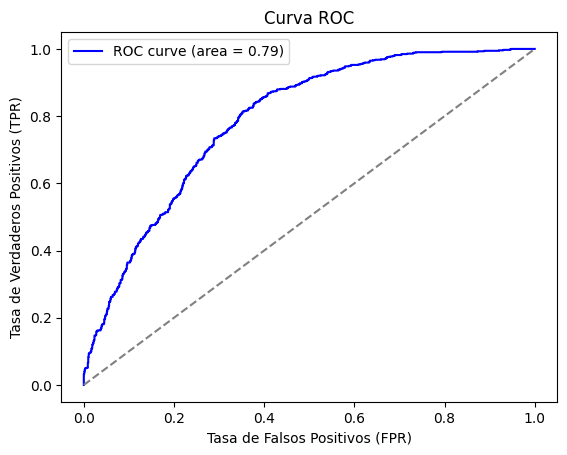

In [ ]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Ajustar el umbral de decisión
new_threshold = 0.4
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.8335607094133697
Recall: 0.8557422969187675
F1-Score: 0.8445058742225292
AUC: 0.9411709619934503


In [ ]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1: 
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 13s 239ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.39
Mejor F1-score: 0.7050691244239632


### XceptionNet

In [ ]:
# Cargar Xception preentrenado en ImageNet, sin la capa superior
base_model = Xception(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout con un 50% de desactivación de neuronas
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-5),  
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc')])  #tf.keras.metrics.F1Score(name='f1_score')]) 

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,  # Generador para los datos de validación
)

Epoch 1/30
253/253 [==============================] - 517s 2s/step - loss: 0.5375 - accuracy: 0.7381 - precision: 0.6781 - recall: 0.6940 - auc: 0.8141 - val_loss: 0.4334 - val_accuracy: 0.7965 - val_precision: 0.8128 - val_recall: 0.6578 - val_auc: 0.8921
Epoch 2/30
253/253 [==============================] - 502s 2s/step - loss: 0.3775 - accuracy: 0.8359 - precision: 0.7988 - recall: 0.8043 - auc: 0.9140 - val_loss: 0.3509 - val_accuracy: 0.8451 - val_precision: 0.8027 - val_recall: 0.8275 - val_auc: 0.9231
Epoch 3/30
253/253 [==============================] - 514s 2s/step - loss: 0.3147 - accuracy: 0.8626 - precision: 0.8406 - recall: 0.8227 - auc: 0.9392 - val_loss: 0.3210 - val_accuracy: 0.8618 - val_precision: 0.8386 - val_recall: 0.8233 - val_auc: 0.9351
Epoch 4/30
253/253 [==============================] - 515s 2s/step - loss: 0.2701 - accuracy: 0.8859 - precision: 0.8681 - recall: 0.8527 - auc: 0.9558 - val_loss: 0.3011 - val_accuracy: 0.8624 - val_precision: 0.8258 - val_recal

In [ ]:
# model.save('modelosFinales/xceptionNet_clasificacionBinaria.keras')

55/55 [==============================] - 49s 893ms/step
Precisión: 0.8629
Recall: 0.8629
F1-Score: 0.8629
AUC: 0.9489


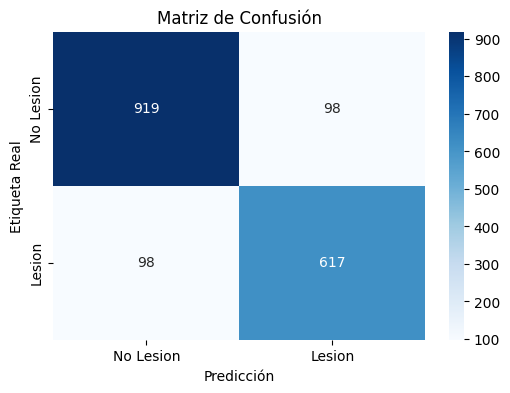

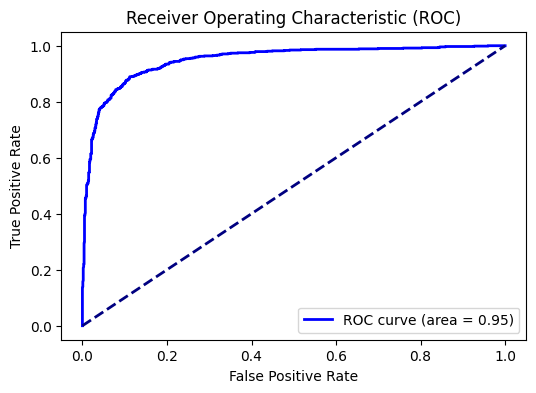

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc as calculate_auc, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

# Obtener las predicciones del modelo en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + (test_generator.samples % test_generator.batch_size > 0)
y_pred_probs = model.predict(test_generator, steps=test_steps)
y_pred = (y_pred_probs[:, 0] > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias con el umbral definido

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]

# Calcular las métricas
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Curva ROC y AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 0]) 
roc_auc = calculate_auc(fpr, tpr)

# Mostrar las métricas y la curva ROC
print(f'Precisión: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {roc_auc:.4f}')

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Lesion', 'Lesion'], yticklabels=['No Lesion', 'Lesion'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1: 
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 52s 939ms/step
Dimensiones de y_pred_proba: (1732, 1)
Dimensiones de y_true: (1732,)
Mejor threshold para F1-score: 0.28
Mejor F1-score: 0.8682593856655291


## 5. Entrenamiento y Evaluación del modelo final (Xception)

In [ ]:
# Configuración de parámetros
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Pesos de clase para manejar el desbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Cargar el modelo base Xception preentrenado en ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True  # Habilitamos el fine-tuning completo

# Congelar las primeras capas para evitar sobreajuste rápido
fine_tune_at = 75
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Definir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Cambio para clasificación binaria
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # Cambio a pérdida binaria
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator_aug,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 678s 2s/step - accuracy: 0.7975 - auc: 0.8819 - loss: 0.4138 - precision: 0.7493 - recall: 0.8456 - val_accuracy: 0.8954 - val_auc: 0.9625 - val_loss: 0.2522 - val_precision: 0.8855 - val_recall: 0.8569 - learning_rate: 1.0000e-04
Epoch 2/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 692s 3s/step - accuracy: 0.9067 - auc: 0.9704 - loss: 0.2237 - precision: 0.8865 - recall: 0.9104 - val_accuracy: 0.9017 - val_auc: 0.9725 - val_loss: 0.2320 - val_precision: 0.8432 - val_recall: 0.9355 - learning_rate: 1.0000e-04
Epoch 3/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 695s 3s/step - accuracy: 0.9442 - auc: 0.9887 - loss: 0.1380 - precision: 0.9284 - recall: 0.9501 - val_accuracy: 0.9145 - val_auc: 0.9695 - val_loss: 0.2200 - val_precision: 0.8951 - val_recall: 0.8976 - learning_rate: 1.0000e-04
Epoch 4/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 658s 2s/step - accuracy: 0.9638 - auc: 0.9937 - loss: 0.1003 - precision: 0.9525 - recall: 0.9675 - val_accuracy: 0.9197 - val_auc: 0.9753 - val_lo

In [ ]:
model.save('modelosFinales/xception_clasificacionBinaria.keras')

In [ ]:
# Obtener las predicciones del modelo en el conjunto de prueba
test_steps = test_generator.samples // test_generator.batch_size + (test_generator.samples % test_generator.batch_size > 0)
y_pred_probs = model.predict(test_generator, steps=test_steps)
y_pred = (y_pred_probs[:, 0] > 0.).astype(int)  # Convertir probabilidades a etiquetas binarias con el umbral definido

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]

# Calcular las métricas
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Curva ROC y AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 0])  
roc_auc = calculate_auc(fpr, tpr)

# Mostrar las métricas y la curva ROC
print(f'Precisión: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {roc_auc:.4f}')

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Lesion', 'Lesion'], yticklabels=['No Lesion', 'Lesion'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [21]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.9082 - auc: 0.4337 - loss: 0.2375 - precision: 0.3102 - recall: 0.4106
Test Loss: 0.24211157858371735
Test Accuracy: 0.9081985950469971
Test Precision: 0.8638743162155151
Test Recall: 0.9230769276618958
Test AUC: 0.9689487814903259


55/55 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step


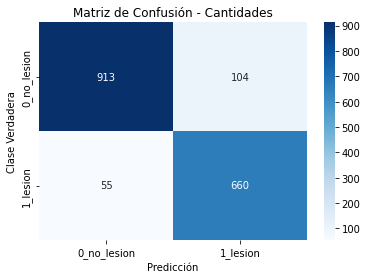

In [26]:
# Generar predicciones binarias
y_pred = (model.predict(test_generator) > 0.5).astype(int)

# Etiquetas reales
y_true = test_generator.classes

# Matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0_no_lesion', '1_lesion'], yticklabels=['0_no_lesion', '1_lesion'])
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - Cantidades')
plt.show()


55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step


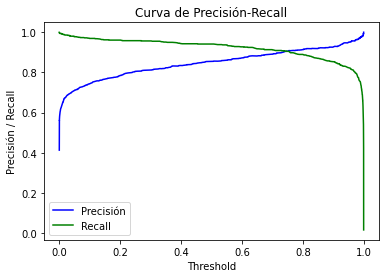

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)] 

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

## Evaluación Modelo Cargado

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 18,073,025 (68.94 MB)

 Non-trainable params: 3,313,256 (12.64 MB)

Found 1732 images belonging to 2 classes.


/Users/achula/miniconda3/envs/proyecto_final/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 48s 852ms/step
              precision    recall  f1-score   support

     Clase 0       0.95      0.93      0.94      1017
     Clase 1       0.90      0.93      0.92       715

    accuracy                           0.93      1732
   macro avg       0.93      0.93      0.93      1732
weighted avg       0.93      0.93      0.93      1732



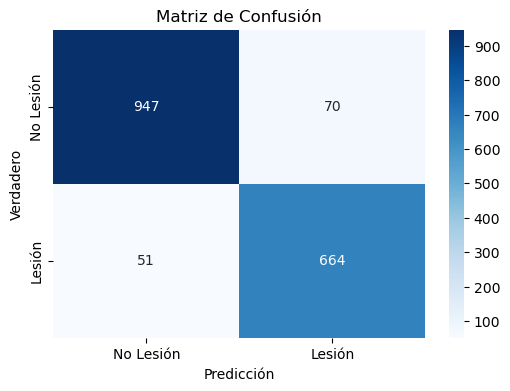

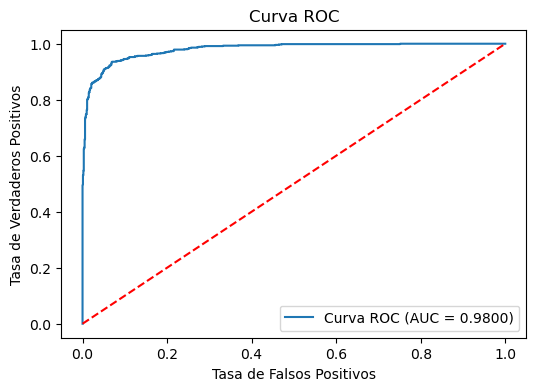

In [36]:
# Cargar el modelo guardado sin compilar
modelo_2clases = load_model('modelosFinales/xception_clasificacion2clases.keras', compile=False)

# Verificar la estructura del modelo
modelo_2clases.summary()

# Configura el generador de imágenes para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'imgs/crops_2classes/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  
    shuffle=False
)

# Predecir las probabilidades en el conjunto de prueba
y_pred_proba = modelo_2clases.predict(test_generator)

# Convertir probabilidades a etiquetas binarias
y_pred = (y_pred_proba > 0.8).astype(int)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes

# Calcular las métricas de evaluación
print(classification_report(y_true, y_pred, target_names=['Clase 0', 'Clase 1']))

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['No Lesión', 'Lesión'], yticklabels=['No Lesión', 'Lesión'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Calcular la curva ROC y el AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = roc_auc_score(y_true, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 820ms/step
Dimensiones de y_pred_proba: (1732, 1)
Dimensiones de y_true: (1732,)
Mejor threshold para optimizar el F1-score: 0.77
Máximo F1-score alcanzado: 0.9194769442532691
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 826ms/step


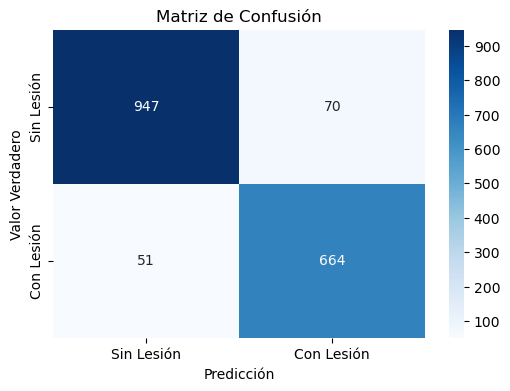

In [38]:
# Obtener las probabilidades predichas y las etiquetas verdaderas
y_pred_proba = modelo_2clases.predict(test_generator)  
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  
    
    # Asegurarse de que haya tanto 0s como 1s
    if len(np.unique(y_pred)) > 1:
        # Calcular precisión, recall y f1-score
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el F1-score máximo y el threshold correspondiente
max_f1 = np.max(f1_scores)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'Mejor threshold para optimizar el F1-score: {best_threshold}')
print(f'Máximo F1-score alcanzado: {max_f1}')

# Matriz de confusión

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = (modelo_2clases.predict(test_generator) > 0.8).astype(int)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

## Busqueda de hiperparámetros de mejor modelo (Xception)

In [ ]:
# Configuración de datos
IMG_HEIGHT, IMG_WIDTH = 224, 224

# Calcular pesos de clase
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Callbacks comunes
early_stopping = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

# Definir HyperModel para Keras Tuner
class XceptionHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        # Modelo base
        base_model = Xception(weights='imagenet', include_top=False, input_shape=self.input_shape)
        base_model.trainable = True

        # Hiperparámetro para el punto de fine-tuning
        fine_tune_at = hp.Choice('fine_tune_at', [50, 75, 100])
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        # Construir el modelo
        inputs = Input(shape=self.input_shape)
        x = base_model(inputs, training=True)
        x = GlobalAveragePooling2D()(x)
        x = Dense(hp.Choice('dense_units', [256, 512, 1024]), activation='relu')(x)
        x = Dropout(hp.Choice('dropout_rate', [0.3, 0.5, 0.6]))(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs, outputs)

        # Compilar modelo
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 5e-5, 1e-5])),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )
        return model

# Inicializar HyperModel
hypermodel = XceptionHyperModel(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=1)

# Configurar Keras Tuner para la búsqueda
tuner = RandomSearch(
    hypermodel,
    objective='val_recall',  # Optimizar por recall
    max_trials=5,  # Número de combinaciones a probar
    executions_per_trial=1,  # Número de ejecuciones por combinación
    directory='hyperparameter_search',
    project_name='xception_binary_classification'
)

# Realizar la búsqueda
tuner.search(
    train_generator_aug,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Mejores hiperparámetros encontrados:")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Fine-tune at layer: {best_hps.get('fine_tune_at')}")
print(f"Dense Units: {best_hps.get('dense_units')}")

# Entrenar el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluar el mejor modelo
results = best_model.evaluate(val_generator)
print("Resultados del mejor modelo:")
print(results)

Trial 5 Complete [02h 13m 28s]
val_recall: 0.9130434989929199

Best val_recall So Far: 0.9312763214111328
Total elapsed time: 1d 04h 25m 34s
Mejores hiperparámetros encontrados:
Learning Rate: 0.0001
Dropout Rate: 0.3
Fine-tune at layer: 50
Dense Units: 256


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 208 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 1018s 4s/step - accuracy: 0.9847 - auc: 0.9988 - loss: 0.0391 - precision: 0.9801 - recall: 0.9865 - val_accuracy: 0.9364 - val_auc: 0.9701 - val_loss: 0.2633 - val_precision: 0.9363 - val_recall: 0.9074 - learning_rate: 1.0000e-04
Epoch 2/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 1035s 4s/step - accuracy: 0.9887 - auc: 0.9991 - loss: 0.0351 - precision: 0.9882 - recall: 0.9874 - val_accuracy: 0.9202 - val_auc: 0.9750 - val_loss: 0.2785 - val_precision: 0.8672 - val_recall: 0.9523 - learning_rate: 1.0000e-04
Epoch 3/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9896 - auc: 0.9992 - loss: 0.0310 - precision: 0.9878 - recall: 0.9890
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
271/271 ━━━━━━━━━━━━━━━━━━━━ 1020s 4s/step - accuracy: 0.9896 - auc: 0.9992 - loss: 0.0311 - precision: 0.9878 - recall: 0.9890 - val_accuracy: 0.9295 - val_auc: 0.9739 - val_loss: 0.2681 - val_precision: 0.9133 - val_recall: 0.9158 - learning_

**Evaluación en test de mejor modelo de busqueda de hiperparametros**

In [33]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.9033 - auc: 0.4372 - loss: 0.2921 - precision: 0.3076 - recall: 0.4282
Test Loss: 0.2745097577571869
Test Accuracy: 0.9139722585678101
Test Precision: 0.8582278490066528
Test Recall: 0.9482517242431641
Test AUC: 0.9752452969551086


55/55 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step


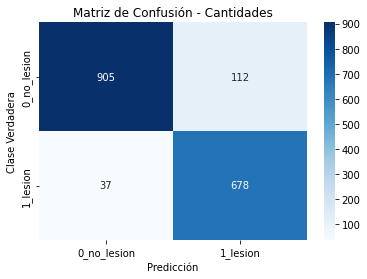

In [ ]:
# Generar predicciones binarias
y_pred = (best_model.predict(test_generator) > 0.5).astype(int)

# Etiquetas reales
y_true = test_generator.classes

# Matriz de confusión

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0_no_lesion', '1_lesion'], yticklabels=['0_no_lesion', '1_lesion'])
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - Cantidades')
plt.show()
